# Florence-2

In [1]:
# !pip install flash-attn --no-build-isolation

In [2]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch
import requests
import copy
%matplotlib inline

In [3]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/home/user/miniconda3/envs/image-classification/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
processor?

Signature:     
processor(
    text: Union[str, List[str], List[List[str]]] = None,
    images: Union[ForwardRef('PIL.Image.Image'), numpy.ndarray, ForwardRef('torch.Tensor'), List[ForwardRef('PIL.Image.Image')], List[numpy.ndarray], List[ForwardRef('torch.Tensor')]] = None,
    tokenize_newline_separately: bool = True,
    padding: Union[bool, str, transformers.utils.generic.PaddingStrategy] = False,
    truncation: Union[bool, str, transformers.tokenization_utils_base.TruncationStrategy] = None,
    max_length=None,
    return_tensors: Union[str, transformers.utils.generic.TensorType, NoneType] = <TensorType.PYTORCH: 'pt'>,
    do_resize: bool = None,
    do_normalize: bool = None,
    image_mean: Union[float, List[float], NoneType] = None,
    image_std: Union[float, List[float], NoneType] = None,
    data_format: Optional[ForwardRef('ChannelDimension')] = 'channels_first',
    input_data_format: Union[str, ForwardRef('ChannelDimension'), NoneType] = None,
    resample: 'PILImageRes

In [5]:
model.generate?

Signature: model.generate(input_ids, inputs_embeds=None, pixel_values=None, **kwargs)
Docstring:
Generates sequences of token ids for models with a language modeling head.

<Tip warning={true}>

Most generation-controlling parameters are set in `generation_config` which, if not passed, will be set to the
model's default generation configuration. You can override any `generation_config` by passing the corresponding
parameters to generate(), e.g. `.generate(inputs, num_beams=4, do_sample=True)`.

For an overview of generation strategies and code examples, check out the [following
guide](../generation_strategies).

</Tip>

Parameters:
    inputs (`torch.Tensor` of varying shape depending on the modality, *optional*):
        The sequence used as a prompt for the generation or as model inputs to the encoder. If `None` the
        method initializes it with `bos_token_id` and a batch size of 1. For decoder-only models `inputs`
        should be in the format of `input_ids`. For encoder-deco

In [6]:
def run_example(task_prompt, image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
        
    inputs = processor(
        text = prompt,
        images = image,
        return_tensors = 'pt').to('cuda', model.dtype)
    
    generated_ids = model.generate(
        input_ids=inputs['input_ids'].cuda(),
        pixel_values=inputs['pixel_values'].cuda(),
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3 # 빔 서치(Beam Search) 알고리즘에서 사용하는 매개변수, 빔의 개수를 의미하며, 숫자가 클수록 더 많은 후보 시퀀스를 동시에 탐색
    )
    
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answers = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )
    
    return parsed_answers

## Sample Image

In [7]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

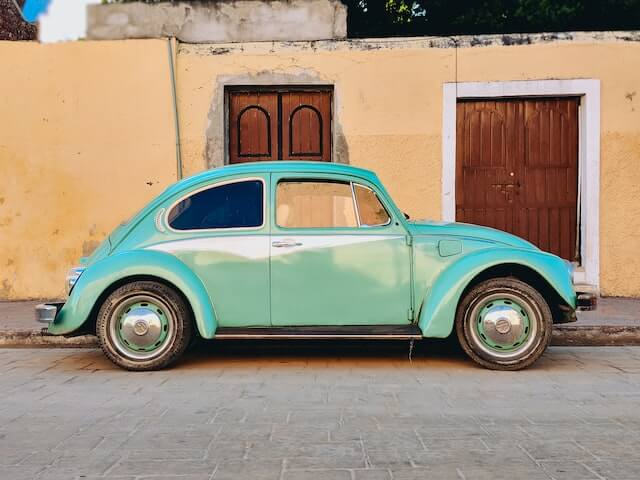

In [8]:
image

## Run pre-defined tasks without additional inputs

### Caption

In [9]:
task_prompt = '<CAPTION>'
run_example(task_prompt, image)

{'<CAPTION>': 'A green car parked in front of a yellow building.'}

In [10]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt, image)

{'<DETAILED_CAPTION>': 'The image shows a green Volkswagen Beetle parked in front of a yellow building with two brown doors. The sky is a mix of blue and white, and there are a few green trees in the background.'}

In [11]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt, image)

{'<MORE_DETAILED_CAPTION>': 'The image shows a vintage Volkswagen Beetle car parked on a cobblestone street in front of a yellow building with two wooden doors. The car is painted in a bright turquoise color and has a white stripe running along the side. It has two doors on either side of the car, one on top of the other, and a small window on the front. The building appears to be old and dilapidated, with peeling paint and crumbling walls. The sky is blue and there are trees in the background.'}

### Object Detection

In [12]:
task_prompt = '<OD>'
results = run_example(task_prompt, image)
print(results)

{'<OD>': {'bboxes': [[34.23999786376953, 160.0800018310547, 597.4400024414062, 371.7599792480469], [456.0, 97.68000030517578, 580.1599731445312, 261.8399963378906], [451.5199890136719, 276.7200012207031, 554.5599975585938, 370.79998779296875], [95.68000030517578, 280.55999755859375, 198.72000122070312, 371.2799987792969]], 'labels': ['car', 'door', 'wheel', 'wheel']}}


In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bbox(image, data):
    fig, ax = plt.subplots()
    
    ax.imshow(image)
    
    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox
        
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        
        ax.add_patch(rect)
        
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
        
    ax.axis('off')
    
    plt.show()


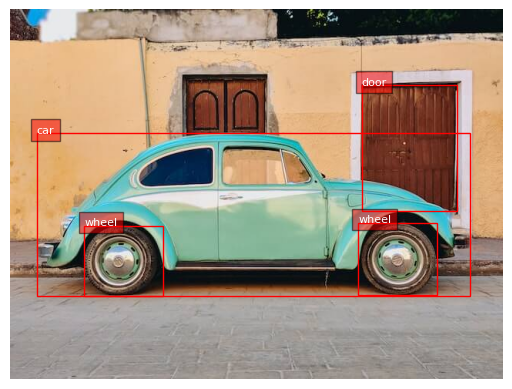

In [14]:
plot_bbox(image, results['<OD>'])

In [15]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt, image)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[33.599998474121094, 160.0800018310547, 596.7999877929688, 371.7599792480469], [450.8800048828125, 276.7200012207031, 553.2799682617188, 370.79998779296875], [95.04000091552734, 280.55999755859375, 197.44000244140625, 371.2799987792969]], 'labels': ['turquoise Volkswagen Beetle', 'wheel', 'wheel']}}


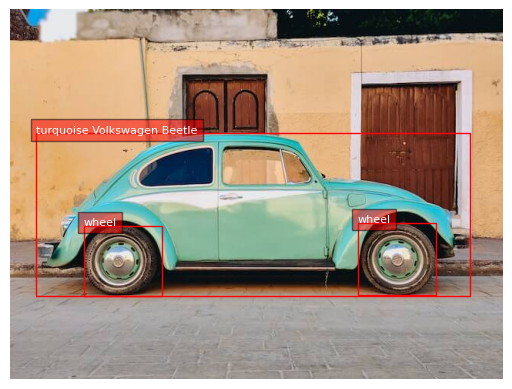

In [16]:
plot_bbox(image, results[f'{task_prompt}'])

In [17]:
task_prompt = '<REGION_PROPOSAL>'
results = run_example(task_prompt, image)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[34.23999786376953, 160.0800018310547, 597.4400024414062, 371.7599792480469], [456.0, 97.68000030517578, 580.1599731445312, 261.8399963378906], [452.1600036621094, 276.7200012207031, 553.9199829101562, 370.79998779296875], [96.31999969482422, 280.55999755859375, 198.72000122070312, 371.2799987792969], [66.87999725341797, 266.6399841308594, 87.36000061035156, 295.91998291015625], [272.32000732421875, 241.67999267578125, 303.67999267578125, 246.95999145507812], [408.6399841308594, 308.3999938964844, 414.3999938964844, 320.8800048828125]], 'labels': ['', '', '', '', '', '', '']}}


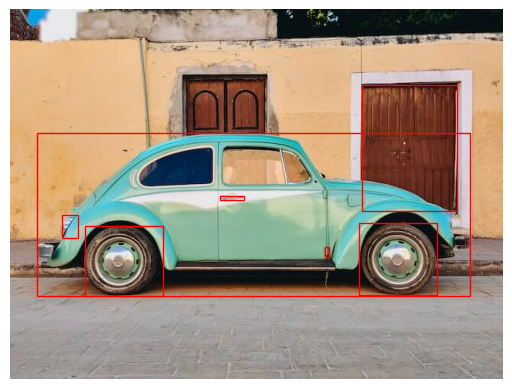

In [18]:
plot_bbox(image, results[f'{task_prompt}'])

### Phrase Grounding

In [19]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, image, text_input="A green car parked in front of a yellow building.")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.880001068115234, 158.63999938964844, 583.3599853515625, 374.6399841308594], [0.3199999928474426, 4.079999923706055, 639.0399780273438, 305.03997802734375]], 'labels': ['A green car', 'a yellow building']}}


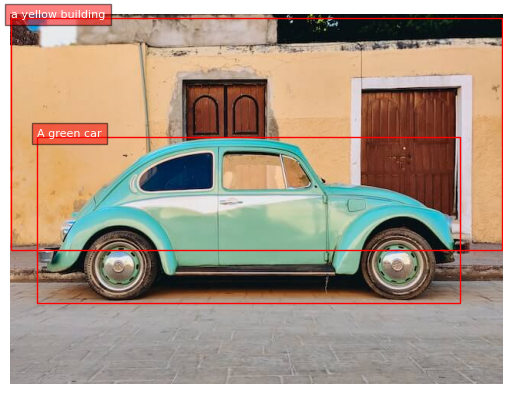

In [20]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

In [21]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, image, text_input="a green car")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[178.87998962402344, 181.67999267578125, 180.8000030517578, 180.72000122070312, 182.72000122070312, 180.72000122070312, 187.83999633789062, 177.83999633789062, 189.75999450683594, 177.83999633789062, 192.95999145507812, 175.9199981689453, 194.87998962402344, 175.9199981689453, 198.0800018310547, 174.0, 200.63999938964844, 173.0399932861328, 203.83999633789062, 172.0800018310547, 207.0399932861328, 170.63999938964844, 209.59999084472656, 169.67999267578125, 214.0800018310547, 168.72000122070312, 217.9199981689453, 167.75999450683594, 221.75999450683594, 166.8000030517578, 226.239990234375, 165.83999633789062, 230.72000122070312, 164.87998962402344, 237.1199951171875, 163.9199981689453, 244.1599884033203, 162.95999145507812, 253.1199951171875, 162.0, 265.2799987792969, 161.0399932861328, 311.3599853515625, 161.0399932861328, 329.2799987792969, 162.0, 338.239990234375, 162.95999145507812, 345.2799987792969, 163.9199981689453, 350.3999

### Referring expression segmentation

In [22]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, image, text_input="a green car")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[178.87998962402344, 181.67999267578125, 180.8000030517578, 180.72000122070312, 182.72000122070312, 180.72000122070312, 187.83999633789062, 177.83999633789062, 189.75999450683594, 177.83999633789062, 192.95999145507812, 175.9199981689453, 194.87998962402344, 175.9199981689453, 198.0800018310547, 174.0, 200.63999938964844, 173.0399932861328, 203.83999633789062, 172.0800018310547, 207.0399932861328, 170.63999938964844, 209.59999084472656, 169.67999267578125, 214.0800018310547, 168.72000122070312, 217.9199981689453, 167.75999450683594, 221.75999450683594, 166.8000030517578, 226.239990234375, 165.83999633789062, 230.72000122070312, 164.87998962402344, 237.1199951171875, 163.9199981689453, 244.1599884033203, 162.95999145507812, 253.1199951171875, 162.0, 265.2799987792969, 161.0399932861328, 311.3599853515625, 161.0399932861328, 329.2799987792969, 162.0, 338.239990234375, 162.95999145507812, 345.2799987792969, 163.9199981689453, 350.3999

In [23]:
from PIL import Image, ImageDraw, ImageFont 
import random
import numpy as np

colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']

def draw_polygons(image, prediction, fill_mask=False):
    
    draw = ImageDraw.Draw(image)  
    
    scale = 1
    
    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None
        
        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * scale).reshape(-1).tolist()
            
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)
                
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill='white')

    display(image)

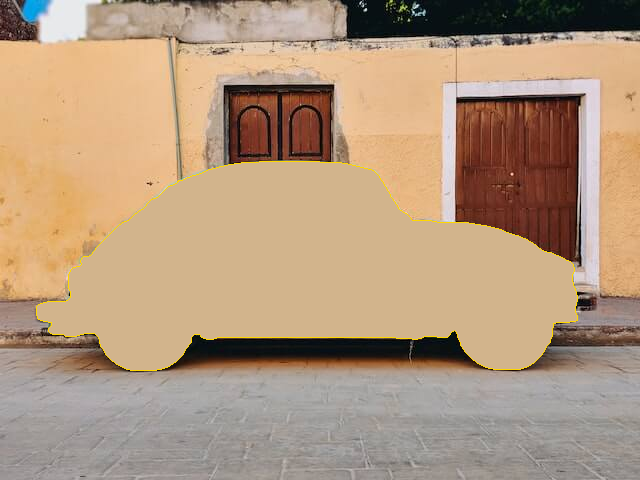

In [24]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)  

### Region to segmentation

In [25]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results = run_example(task_prompt, image, text_input="<loc_702><loc_575><loc_866><loc_772>")
print(results)

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[470.0799865722656, 288.239990234375, 473.91998291015625, 285.3599853515625, 477.1199951171875, 283.44000244140625, 479.03997802734375, 282.47998046875, 480.9599914550781, 282.47998046875, 484.1600036621094, 280.55999755859375, 486.7200012207031, 279.6000061035156, 489.91998291015625, 278.6399841308594, 495.03997802734375, 277.67999267578125, 512.3200073242188, 277.67999267578125, 514.8800048828125, 278.6399841308594, 518.0800170898438, 279.6000061035156, 521.2799682617188, 281.5199890136719, 523.2000122070312, 281.5199890136719, 525.1199951171875, 283.44000244140625, 528.3200073242188, 284.3999938964844, 530.8800048828125, 286.32000732421875, 534.0800170898438, 288.239990234375, 543.0399780273438, 297.3599853515625, 544.9599609375, 300.239990234375, 546.8800048828125, 303.1199951171875, 550.0800170898438, 309.3599853515625, 551.3599853515625, 312.239990234375, 552.0, 315.1199951171875, 553.2799682617188, 319.44000244140625, 553.2799682617188

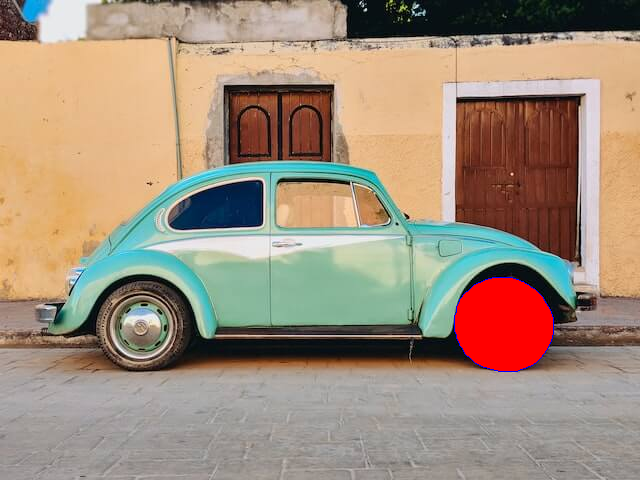

In [26]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REGION_TO_SEGMENTATION>'], fill_mask=True)  

### Open vocabulary detection

open vocabulary detection can detect both objects and ocr texts.

results format:

{ '<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]], 'bboxes_labels': ['label_1', 'label_2', ..], 'polygons': [[[x1, y1, x2, y2, ..., xn, yn], [x1, y1, ..., xn, yn]], ...], 'polygons_labels': ['label_1', 'label_2', ...] }}

In [27]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
results = run_example(task_prompt, image, text_input="a green car")
print(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[34.23999786376953, 158.63999938964844, 582.719970703125, 374.1600036621094]], 'bboxes_labels': ['a green car'], 'polygons': [], 'polygons_labels': []}}


In [28]:
def convert_to_od_format(data):  
    """  
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.  
  
    Parameters:  
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.  
  
    Returns:  
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.  
    """  
    # Extract bounding boxes and labels  
    bboxes = data.get('bboxes', [])  
    labels = data.get('bboxes_labels', [])  
      
    # Construct the output format  
    od_results = {  
        'bboxes': bboxes,  
        'labels': labels  
    }  
      
    return od_results 

In [29]:
bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

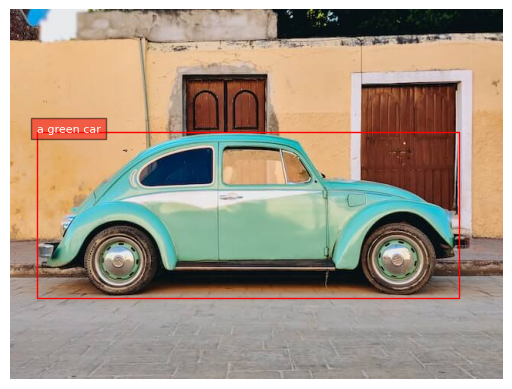

In [30]:
plot_bbox(image, bbox_results)

In [31]:
task_prompt = '<REGION_TO_CATEGORY>'
results = run_example(task_prompt, image, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_CATEGORY>': 'car<loc_52><loc_332><loc_932><loc_774>'}


In [32]:
task_prompt = '<REGION_TO_DESCRIPTION>'
results = run_example(task_prompt, image, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_DESCRIPTION>': 'turquoise Volkswagen Beetle<loc_52><loc_332><loc_932><loc_774>'}


### OCR

In [33]:
url = "http://ecx.images-amazon.com/images/I/51UUzBDAMsL.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

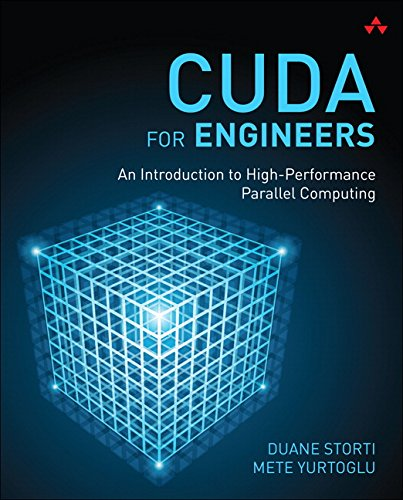

In [34]:
image

In [35]:
task_prompt = '<OCR>'
run_example(task_prompt, image)

{'<OCR>': 'CUDAFOR ENGINEERSAn Introduction to High-PerformanceParallel ComputingDUANE STORTIMETE YURTOGLU'}

In [36]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt, image)
print(results)
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

{'<OCR_WITH_REGION>': {'quad_boxes': [[167.0435028076172, 50.25, 374.9914855957031, 50.25, 374.9914855957031, 114.75, 167.0435028076172, 114.75], [144.8784942626953, 120.75, 374.9914855957031, 120.75, 374.9914855957031, 149.25, 144.8784942626953, 149.25], [115.86249542236328, 165.25, 377.0065002441406, 166.25, 377.0065002441406, 184.25, 115.86249542236328, 183.25], [239.9864959716797, 184.25, 377.0065002441406, 186.25, 377.0065002441406, 204.25, 239.9864959716797, 202.25], [266.5845031738281, 441.25, 377.0065002441406, 441.25, 377.0065002441406, 456.25, 266.5845031738281, 456.25], [251.27049255371094, 460.25, 377.0065002441406, 460.25, 377.0065002441406, 475.25, 251.27049255371094, 475.25]], 'labels': ['</s>CUDA', 'FOR ENGINEERS', 'An Introduction to High-Performance', 'Parallel Computing', 'DUANE STORTI', 'METE YURTOGLU']}}


In [37]:
def draw_ocr_bboxes(image, prediction, scale=1):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",
        
                    fill=color)
       
    display(image)

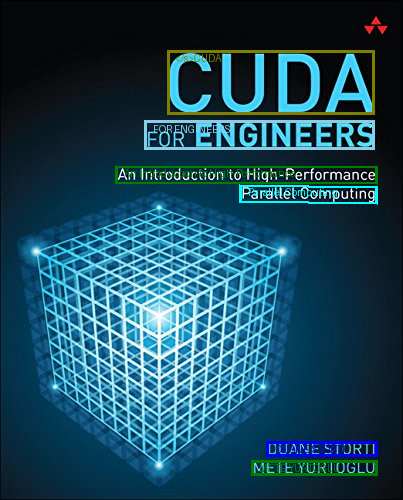

In [38]:
draw_ocr_bboxes(image, results['<OCR_WITH_REGION>'])

## Cascaded tasks

### Caption + Phrase Grounding
results format:

{ '<CAPTION': pure_text, {'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}} }

In [39]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

In [40]:
task_prompt = '<CAPTION>'
results = run_example(task_prompt, image)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, image, text_input)
results['<CAPTION>'] = text_input

In [41]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.880001068115234,
    158.63999938964844,
    583.3599853515625,
    374.6399841308594],
   [0.3199999928474426,
    4.079999923706055,
    639.0399780273438,
    305.03997802734375]],
  'labels': ['A green car', 'a yellow building']},
 '<CAPTION>': 'A green car parked in front of a yellow building.'}

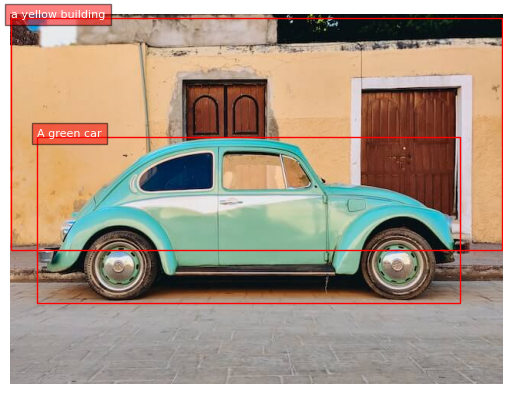

In [42]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

###  Detailed Caption + Phrase Grounding
results format:

{ '<DETAILED_CAPTION': pure_text, {'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}} }

In [43]:
task_prompt = '<DETAILED_CAPTION>'
results = run_example(task_prompt, image)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, image, text_input)
results['<DETAILED_CAPTION>'] = text_input

In [44]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.23999786376953,
    158.16000366210938,
    583.3599853515625,
    374.1600036621094],
   [0.3199999928474426,
    4.559999942779541,
    639.0399780273438,
    304.55999755859375],
   [454.0799865722656, 94.31999969482422, 582.0800170898438, 264.239990234375],
   [224.3199920654297,
    84.72000122070312,
    335.03997802734375,
    165.83999633789062],
   [0.3199999928474426,
    1.1999999284744263,
    639.0399780273438,
    42.959999084472656],
   [0.3199999928474426,
    1.1999999284744263,
    103.36000061035156,
    43.91999816894531],
   [0.3199999928474426,
    1.1999999284744263,
    638.3999633789062,
    42.959999084472656],
   [345.91998291015625,
    1.1999999284744263,
    639.0399780273438,
    39.119998931884766]],
  'labels': ['a green Volkswagen Beetle',
   'a yellow building',
   'brown doors',
   'brown doors',
   'The sky',
   'The sky',
   'a few green trees',
   'a few green trees']},
 '<DETAILED_CAPTION>': 'The 

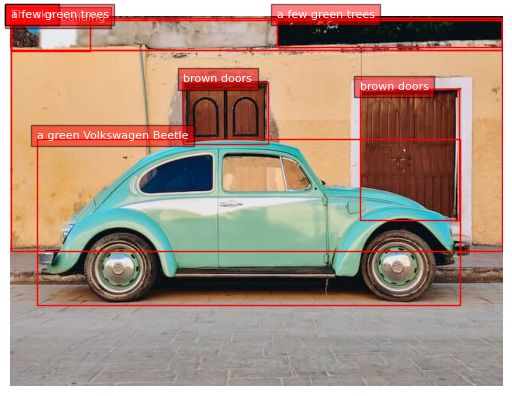

In [45]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### More Detailed Caption + Phrase Grounding
results format:

{ '<MORE_DETAILED_CAPTION': pure_text, {'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}} }

In [46]:
task_prompt = '<MORE_DETAILED_CAPTION>'
results = run_example(task_prompt, image)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, image, text_input)
results['<MORE_DETAILED_CAPTION>'] = text_input

In [47]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[35.52000045776367,
    157.67999267578125,
    581.4400024414062,
    372.7200012207031],
   [0.3199999928474426,
    340.55999755859375,
    639.0399780273438,
    479.2799987792969],
   [454.7200012207031,
    93.83999633789062,
    582.0800170898438,
    263.2799987792969],
   [224.3199920654297,
    84.23999786376953,
    335.03997802734375,
    164.39999389648438],
   [35.52000045776367,
    157.1999969482422,
    581.4400024414062,
    372.7200012207031],
   [454.7200012207031,
    93.83999633789062,
    581.4400024414062,
    263.2799987792969],
   [224.3199920654297,
    84.72000122070312,
    335.03997802734375,
    163.9199981689453],
   [165.44000244140625,
    177.36000061035156,
    266.55999755859375,
    232.0800018310547],
   [0.3199999928474426,
    5.039999961853027,
    639.0399780273438,
    301.67999267578125],
   [0.3199999928474426, 0.7199999690055847, 639.0399780273438, 42.0],
   [20.799999237060547,
    0.719999969

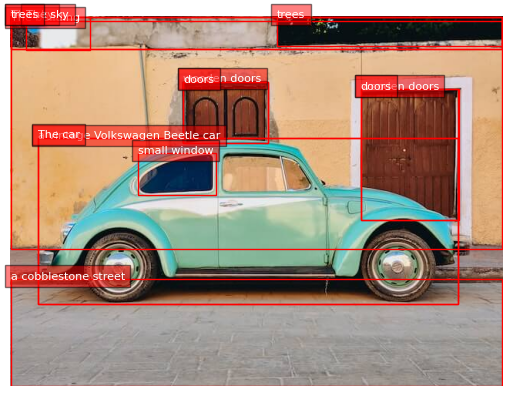

In [48]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

## Inference with roboflow supervision

In [49]:
import cv2
import supervision as sv
print(f'supervision version: {sv.__version__}')

from tqdm import tqdm
from PIL import Image

import os
HOME = os.getcwd()
print(HOME)

supervision version: 0.22.0
/home/user/res/image-retrieval-db


In [50]:
SOURCE_VIDEO_PATH = f"{HOME}/vlc-record-2024-09-12-17h11m17s-rtsp___192.168.0.51_554_-.avi"
TARGET_VIDEO_PATH = f"{HOME}/florence2-lotte-output.mp4"

In [51]:
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [52]:
def convert_to_od_format(data):  
    """  
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.  
  
    Parameters:  
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.  
  
    Returns:  
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.  
    """  
    # Extract bounding boxes and labels  
    bboxes = data.get('bboxes', [])  
    labels = data.get('bboxes_labels', [])  
      
    # Construct the output format  
    od_results = {  
        'bboxes': bboxes,  
        'labels': labels  
    }  
      
    return od_results 

In [63]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
text_input = "the product held in hand"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

width, height = video_info.resolution_wh
frame_area = width * height

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        
        # convert numpy to PIL.Image
        frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        results = run_example(task_prompt, frame, text_input=text_input)
        
        # responses = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])
        
        # if responses['bboxes'] == []:
        #     continue
        
        # responses = {
        #     '<OPEN_VOCABULARY_DETECTION>': responses
        # }
        
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, results, resolution_wh=(frame.width, frame.height))
        # detections = detections[(detections.area / frame_area) < 0.10]

        detections.class_id = [0] * len(detections)
        detections.confidence = [1.0] * len(detections)
        annotated_frame = frame.copy()
        annotated_frame = BOUNDING_BOX_ANNOTATOR.annotate(annotated_frame, detections)
        annotated_frame = LABEL_ANNOTATOR.annotate(annotated_frame, detections)
        # convert PIL.Image to numpy
        annotated_frame = cv2.cvtColor(np.array(annotated_frame), cv2.COLOR_RGB2BGR)
        sink.write_frame(annotated_frame)

  0%|          | 0/415 [00:00<?, ?it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2904.9599609375, 359.6400146484375, 3031.679931640625, 519.4800415039062]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  0%|          | 2/415 [00:01<05:53,  1.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2912.639892578125, 340.20001220703125, 3031.679931640625, 497.8800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  1%|          | 3/415 [00:02<04:46,  1.44it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2916.47998046875, 333.7200012207031, 3024.0, 471.96002197265625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  1%|          | 4/415 [00:02<04:12,  1.63it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2920.31982421875, 316.44000244140625, 3027.83984375, 461.1600036621094]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  1%|          | 5/415 [00:03<04:03,  1.69it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2920.31982421875, 297.0, 3027.83984375, 446.0400085449219]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  1%|▏         | 6/415 [00:03<03:41,  1.85it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2924.159912109375, 288.3600158691406, 3027.83984375, 428.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  2%|▏         | 7/415 [00:04<03:28,  1.96it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2931.83984375, 260.2799987792969, 3035.52001953125, 385.5600280761719]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  2%|▏         | 8/415 [00:04<03:18,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2947.199951171875, 223.5600128173828, 3054.719970703125, 312.1200256347656]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  2%|▏         | 9/415 [00:05<03:14,  2.08it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2924.159912109375, 210.60000610351562, 3054.719970703125, 314.2799987792969]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  2%|▏         | 10/415 [00:05<03:10,  2.13it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2536.31982421875, 882.3600463867188, 2674.56005859375, 1022.7600708007812]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  3%|▎         | 11/415 [00:06<03:06,  2.16it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2997.119873046875, 189.0, 3085.43994140625, 318.6000061035156]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  3%|▎         | 12/415 [00:06<03:03,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3000.9599609375, 180.36000061035156, 3089.280029296875, 312.1200256347656]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  3%|▎         | 13/415 [00:06<03:02,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3004.800048828125, 180.36000061035156, 3096.9599609375, 305.6400146484375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  3%|▎         | 14/415 [00:07<03:02,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3008.639892578125, 156.60000610351562, 3108.47998046875, 305.6400146484375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  4%|▎         | 15/415 [00:07<03:00,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3012.47998046875, 152.27999877929688, 3146.8798828125, 301.32000732421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  4%|▍         | 16/415 [00:08<03:01,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3016.31982421875, 147.9600067138672, 3146.8798828125, 299.1600036621094]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  4%|▍         | 17/415 [00:08<03:00,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2117.760009765625, 1258.2000732421875, 2294.39990234375, 1454.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  4%|▍         | 18/415 [00:09<02:58,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2060.159912109375, 1323.0, 2240.639892578125, 1541.1600341796875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  5%|▍         | 19/415 [00:09<02:58,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1991.0399169921875, 1394.280029296875, 2190.719970703125, 1625.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  5%|▍         | 20/415 [00:10<02:57,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1948.7999267578125, 1441.800048828125, 2148.47998046875, 1709.6400146484375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  5%|▌         | 21/415 [00:10<02:56,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1929.5999755859375, 1506.60009765625, 2136.9599609375, 1793.880126953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  5%|▌         | 22/415 [00:11<02:55,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1914.239990234375, 1567.080078125, 2140.800048828125, 1878.1201171875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  6%|▌         | 23/415 [00:11<02:56,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1887.3599853515625, 1642.6800537109375, 2133.119873046875, 1986.1201171875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  6%|▌         | 24/415 [00:11<02:55,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3012.47998046875, 158.760009765625, 3108.47998046875, 286.20001220703125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  6%|▌         | 25/415 [00:12<02:55,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3012.47998046875, 156.60000610351562, 3108.47998046875, 286.20001220703125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  6%|▋         | 26/415 [00:12<02:55,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3008.639892578125, 158.760009765625, 3104.639892578125, 286.20001220703125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  7%|▋         | 27/415 [00:13<02:54,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3008.639892578125, 158.760009765625, 3104.639892578125, 286.20001220703125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  7%|▋         | 28/415 [00:13<02:53,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3004.800048828125, 163.0800018310547, 3100.800048828125, 286.20001220703125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  7%|▋         | 29/415 [00:14<02:53,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3004.800048828125, 165.24000549316406, 3100.800048828125, 286.20001220703125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  7%|▋         | 30/415 [00:14<02:52,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3004.800048828125, 165.24000549316406, 3096.9599609375, 286.20001220703125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  7%|▋         | 31/415 [00:15<02:55,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3004.800048828125, 169.5600128173828, 3100.800048828125, 290.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  8%|▊         | 32/415 [00:15<02:56,  2.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3004.800048828125, 169.5600128173828, 3104.639892578125, 297.0]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  8%|▊         | 33/415 [00:16<02:56,  2.16it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3004.800048828125, 171.72000122070312, 3104.639892578125, 305.6400146484375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  8%|▊         | 34/415 [00:16<02:58,  2.13it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3000.9599609375, 169.5600128173828, 3096.9599609375, 312.1200256347656]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  8%|▊         | 35/415 [00:17<02:59,  2.12it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2997.119873046875, 173.8800048828125, 3093.119873046875, 318.6000061035156]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  9%|▊         | 36/415 [00:17<02:57,  2.14it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2989.43994140625, 186.8400115966797, 3089.280029296875, 329.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  9%|▉         | 37/415 [00:17<02:54,  2.16it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2981.760009765625, 208.44000244140625, 3081.599853515625, 348.84002685546875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  9%|▉         | 38/415 [00:18<02:53,  2.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2962.559814453125, 214.92001342773438, 3066.239990234375, 340.20001220703125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


  9%|▉         | 39/415 [00:18<02:54,  2.15it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1488.0, 2009.880126953125, 1910.39990234375, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 10%|▉         | 40/415 [00:19<02:54,  2.15it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1511.0399169921875, 1832.7601318359375, 1941.1199951171875, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 10%|▉         | 41/415 [00:19<02:52,  2.16it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1541.760009765625, 1599.4801025390625, 1975.679931640625, 2066.0400390625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 10%|█         | 42/415 [00:20<02:50,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1584.0, 1474.2000732421875, 1998.719970703125, 1880.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 10%|█         | 43/415 [00:20<02:49,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1614.719970703125, 1348.9200439453125, 2014.0799560546875, 1729.080078125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 11%|█         | 44/415 [00:21<02:47,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1633.919921875, 1275.4801025390625, 2025.5999755859375, 1640.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 11%|█         | 45/415 [00:21<02:47,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1637.760009765625, 1253.8800048828125, 2029.43994140625, 1612.4400634765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 11%|█         | 46/415 [00:22<02:56,  2.09it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1633.919921875, 1256.0400390625, 2017.919921875, 1612.4400634765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 11%|█▏        | 47/415 [00:22<02:54,  2.11it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1622.4000244140625, 1275.4801025390625, 2010.239990234375, 1636.2000732421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 12%|█▏        | 48/415 [00:23<02:50,  2.15it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1614.719970703125, 1303.56005859375, 2002.5599365234375, 1657.800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 12%|█▏        | 49/415 [00:23<02:47,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1610.8800048828125, 1320.840087890625, 1998.719970703125, 1664.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 12%|█▏        | 50/415 [00:23<02:46,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1607.0399169921875, 1318.6800537109375, 1998.719970703125, 1664.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 12%|█▏        | 51/415 [00:24<02:44,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1603.199951171875, 1312.2000732421875, 1991.0399169921875, 1672.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 13%|█▎        | 52/415 [00:24<02:42,  2.24it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1595.52001953125, 1314.360107421875, 1979.5198974609375, 1664.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 13%|█▎        | 53/415 [00:25<02:41,  2.24it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1584.0, 1333.800048828125, 1964.159912109375, 1692.360107421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 13%|█▎        | 54/415 [00:25<02:40,  2.24it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1564.7999267578125, 1387.800048828125, 1952.6400146484375, 1767.9600830078125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 13%|█▎        | 55/415 [00:26<02:40,  2.24it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1534.0799560546875, 1485.0, 1948.7999267578125, 1910.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 13%|█▎        | 56/415 [00:26<02:40,  2.24it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1507.199951171875, 1599.4801025390625, 1933.43994140625, 2120.0400390625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 14%|█▎        | 57/415 [00:27<02:41,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1491.8399658203125, 1891.080078125, 1914.239990234375, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 14%|█▍        | 58/415 [00:27<02:40,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1484.159912109375, 1940.7601318359375, 1829.760009765625, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 14%|█▍        | 59/415 [00:27<02:40,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2490.239990234375, 243.00001525878906, 2597.760009765625, 329.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 14%|█▍        | 60/415 [00:28<02:38,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2455.679931640625, 251.6400146484375, 2593.919921875, 342.3600158691406]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 15%|█▍        | 61/415 [00:28<02:38,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2440.31982421875, 260.2799987792969, 2574.719970703125, 346.6800231933594]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 15%|█▍        | 62/415 [00:29<02:39,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2428.800048828125, 268.9200134277344, 2528.639892578125, 348.84002685546875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 15%|█▌        | 63/415 [00:29<02:39,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2359.679931640625, 299.1600036621094, 2494.079833984375, 489.2400207519531]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 15%|█▌        | 64/415 [00:30<02:37,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2386.56005859375, 286.20001220703125, 2494.079833984375, 448.20001220703125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 16%|█▌        | 65/415 [00:30<02:37,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2474.8798828125, 271.08001708984375, 2590.079833984375, 351.0]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 16%|█▌        | 66/415 [00:31<02:36,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2501.760009765625, 1.0800000429153442, 3039.35986328125, 761.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 16%|█▌        | 67/415 [00:31<02:36,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2536.31982421875, 301.32000732421875, 2643.83984375, 379.08001708984375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 16%|█▋        | 68/415 [00:31<02:36,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2547.83984375, 314.2799987792969, 2643.83984375, 422.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 17%|█▋        | 69/415 [00:32<02:35,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2555.52001953125, 320.760009765625, 2640.0, 420.1200256347656]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 17%|█▋        | 70/415 [00:32<02:34,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2555.52001953125, 320.760009765625, 2643.83984375, 420.1200256347656]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 17%|█▋        | 71/415 [00:33<02:34,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2555.52001953125, 318.6000061035156, 2643.83984375, 420.1200256347656]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 17%|█▋        | 72/415 [00:33<02:34,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2555.52001953125, 320.760009765625, 2640.0, 420.1200256347656]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 18%|█▊        | 73/415 [00:34<02:33,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1941.1199951171875, 1895.4000244140625, 2390.39990234375, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 18%|█▊        | 74/415 [00:34<02:33,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1921.919921875, 1711.800048828125, 2363.52001953125, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 18%|█▊        | 75/415 [00:35<02:33,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1872.0, 1554.1201171875, 2317.43994140625, 1990.4400634765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 18%|█▊        | 76/415 [00:35<02:35,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1814.39990234375, 1439.6400146484375, 2263.679931640625, 1847.880126953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 19%|█▊        | 77/415 [00:36<02:34,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1810.5599365234375, 1370.52001953125, 2217.599853515625, 1750.6800537109375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 19%|█▉        | 78/415 [00:36<02:33,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1787.52001953125, 1329.4801025390625, 2186.8798828125, 1696.6800537109375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 19%|█▉        | 79/415 [00:36<02:32,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1768.3199462890625, 1312.2000732421875, 2163.83984375, 1672.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 19%|█▉        | 80/415 [00:37<02:31,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1756.7999267578125, 1305.7200927734375, 2144.639892578125, 1664.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 20%|█▉        | 81/415 [00:37<02:31,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1745.2799072265625, 1305.7200927734375, 2129.280029296875, 1668.60009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 20%|█▉        | 82/415 [00:38<02:29,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1745.2799072265625, 1310.0400390625, 2125.43994140625, 1672.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 20%|██        | 83/415 [00:38<02:29,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1745.2799072265625, 1314.360107421875, 2129.280029296875, 1677.2401123046875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 20%|██        | 84/415 [00:39<02:28,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1752.9599609375, 1329.4801025390625, 2140.800048828125, 1690.2000732421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 20%|██        | 85/415 [00:39<02:28,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1764.47998046875, 1346.760009765625, 2160.0, 1716.1201171875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 21%|██        | 86/415 [00:40<02:28,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1779.8399658203125, 1387.800048828125, 2186.8798828125, 1787.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 21%|██        | 87/415 [00:40<02:28,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1799.0399169921875, 1467.7200927734375, 2225.280029296875, 1888.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 21%|██        | 88/415 [00:41<02:26,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1822.0799560546875, 1580.0400390625, 2275.199951171875, 2040.1201171875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 21%|██▏       | 89/415 [00:41<02:26,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1872.0, 1720.4400634765625, 2328.9599609375, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 22%|██▏       | 90/415 [00:41<02:25,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1929.5999755859375, 1897.56005859375, 2371.199951171875, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 22%|██▏       | 91/415 [00:42<02:27,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3008.639892578125, 387.7200012207031, 3100.800048828125, 506.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 22%|██▏       | 92/415 [00:42<02:27,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3039.35986328125, 405.0000305175781, 3131.52001953125, 523.800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 22%|██▏       | 93/415 [00:43<02:26,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3066.239990234375, 415.8000183105469, 3162.239990234375, 536.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 23%|██▎       | 94/415 [00:43<02:25,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3096.9599609375, 435.2400207519531, 3189.119873046875, 556.2000122070312]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 23%|██▎       | 95/415 [00:44<02:25,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3123.83984375, 446.0400085449219, 3216.0, 564.8400268554688]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 23%|██▎       | 96/415 [00:44<02:24,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3143.0400390625, 459.0000305175781, 3239.0400390625, 579.9600219726562]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 23%|██▎       | 97/415 [00:45<02:23,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2010.239990234375, 1990.4400634765625, 2259.83984375, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 24%|██▎       | 98/415 [00:45<02:24,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3189.119873046875, 489.2400207519531, 3277.43994140625, 610.2000122070312]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 24%|██▍       | 99/415 [00:46<02:23,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3196.800048828125, 504.3600158691406, 3288.9599609375, 623.1600341796875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 24%|██▍       | 100/415 [00:46<02:21,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2282.8798828125, 303.4800109863281, 2490.239990234375, 500.0400085449219]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 24%|██▍       | 101/415 [00:46<02:21,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3219.83984375, 536.760009765625, 3319.679931640625, 657.7200317382812]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 25%|██▍       | 102/415 [00:47<02:20,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 556.2000122070312, 3335.0400390625, 657.7200317382812]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 25%|██▍       | 103/415 [00:47<02:21,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3265.919921875, 575.6400146484375, 3354.239990234375, 681.4800415039062]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 25%|██▌       | 104/415 [00:48<02:20,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3277.43994140625, 597.2400512695312, 3365.760009765625, 703.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 25%|██▌       | 105/415 [00:48<02:19,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3288.9599609375, 618.8400268554688, 3384.9599609375, 739.800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 26%|██▌       | 106/415 [00:49<02:20,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3265.919921875, 659.8800048828125, 3384.9599609375, 767.8800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 26%|██▌       | 107/415 [00:49<02:20,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3292.7998046875, 657.7200317382812, 3423.35986328125, 789.4800415039062]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 26%|██▌       | 108/415 [00:50<02:20,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2271.35986328125, 307.8000183105469, 2490.239990234375, 528.1199951171875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 26%|██▋       | 109/415 [00:50<02:18,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3361.919921875, 685.800048828125, 3461.760009765625, 811.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 27%|██▋       | 110/415 [00:51<02:19,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2271.35986328125, 307.8000183105469, 2490.239990234375, 528.1199951171875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 27%|██▋       | 111/415 [00:51<02:18,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2275.199951171875, 309.96002197265625, 2490.239990234375, 528.1199951171875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 27%|██▋       | 112/415 [00:51<02:17,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3400.31982421875, 735.4800415039062, 3504.0, 882.3600463867188]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 27%|██▋       | 113/415 [00:52<02:17,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1649.2799072265625, 2025.0001220703125, 1837.43994140625, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 27%|██▋       | 114/415 [00:52<02:16,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1641.5999755859375, 2009.880126953125, 1833.5999755859375, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 28%|██▊       | 115/415 [00:53<02:16,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3381.119873046875, 806.760009765625, 3530.8798828125, 947.1600341796875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 28%|██▊       | 116/415 [00:53<02:15,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1541.760009765625, 2040.1201171875, 1925.760009765625, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 28%|██▊       | 117/415 [00:54<02:16,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1553.2799072265625, 1999.080078125, 1944.9599609375, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 28%|██▊       | 118/415 [00:54<02:15,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1568.6400146484375, 1919.1600341796875, 1971.8399658203125, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 29%|██▊       | 119/415 [00:55<02:14,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1587.8399658203125, 1854.360107421875, 1991.0399169921875, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 29%|██▉       | 120/415 [00:55<02:13,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1610.8800048828125, 1789.56005859375, 2002.5599365234375, 2126.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 29%|██▉       | 121/415 [00:55<02:12,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1622.4000244140625, 1755.0001220703125, 2002.5599365234375, 2072.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 29%|██▉       | 122/415 [00:56<02:13,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1618.5599365234375, 1761.4801025390625, 1991.0399169921875, 2070.360107421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 30%|██▉       | 123/415 [00:56<02:12,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1603.199951171875, 1776.60009765625, 1979.5198974609375, 2087.64013671875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 30%|██▉       | 124/415 [00:57<02:11,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1591.679931640625, 1793.880126953125, 1979.5198974609375, 2104.920166015625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 30%|███       | 125/415 [00:57<02:11,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1587.8399658203125, 1821.9600830078125, 1991.0399169921875, 2139.47998046875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 30%|███       | 126/415 [00:58<02:10,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1580.159912109375, 1871.6400146484375, 1983.3599853515625, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 31%|███       | 127/415 [00:58<02:10,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1572.47998046875, 1947.2401123046875, 1975.679931640625, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 31%|███       | 128/415 [00:59<02:09,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1568.6400146484375, 2031.4801025390625, 1968.0, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 31%|███       | 129/415 [00:59<02:09,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1703.0399169921875, 1996.9200439453125, 1872.0, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 31%|███▏      | 130/415 [01:00<02:08,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3546.239990234375, 1126.4400634765625, 3680.639892578125, 1260.360107421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 32%|███▏      | 131/415 [01:00<02:08,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3553.919921875, 1139.4000244140625, 3722.8798828125, 1286.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 32%|███▏      | 132/415 [01:00<02:08,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3557.760009765625, 1163.1600341796875, 3730.559814453125, 1314.360107421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 32%|███▏      | 133/415 [01:01<02:07,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3557.760009765625, 1182.60009765625, 3726.719970703125, 1329.4801025390625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 32%|███▏      | 134/415 [01:01<02:07,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3553.919921875, 1197.7200927734375, 3692.159912109375, 1346.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 33%|███▎      | 135/415 [01:02<02:07,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3550.079833984375, 1206.360107421875, 3726.719970703125, 1366.2000732421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 33%|███▎      | 136/415 [01:02<02:07,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3550.079833984375, 1215.0, 3722.8798828125, 1372.6800537109375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 33%|███▎      | 137/415 [01:03<02:07,  2.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1549.43994140625, 2003.4000244140625, 1956.47998046875, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 33%|███▎      | 138/415 [01:03<02:06,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1545.5999755859375, 1906.2000732421875, 1964.159912109375, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 33%|███▎      | 139/415 [01:04<02:06,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1534.0799560546875, 1802.52001953125, 1952.6400146484375, 2137.320068359375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 34%|███▎      | 140/415 [01:04<02:05,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1526.4000244140625, 1705.320068359375, 1941.1199951171875, 2044.4400634765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 34%|███▍      | 141/415 [01:05<02:05,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1522.5599365234375, 1599.4801025390625, 1933.43994140625, 1940.7601318359375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 34%|███▍      | 142/415 [01:05<02:04,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1522.5599365234375, 1521.7200927734375, 1929.5999755859375, 1847.880126953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 34%|███▍      | 143/415 [01:06<02:04,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1522.5599365234375, 1450.4400634765625, 1925.760009765625, 1772.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 35%|███▍      | 144/415 [01:06<02:03,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1522.5599365234375, 1398.60009765625, 1925.760009765625, 1713.9600830078125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 35%|███▍      | 145/415 [01:06<02:02,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1530.239990234375, 1372.6800537109375, 1929.5999755859375, 1688.0400390625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 35%|███▌      | 146/415 [01:07<02:02,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1530.239990234375, 1346.760009765625, 1933.43994140625, 1668.60009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 35%|███▌      | 147/415 [01:07<02:02,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1534.0799560546875, 1342.4400634765625, 1937.2799072265625, 1657.800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 36%|███▌      | 148/415 [01:08<02:01,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1541.760009765625, 1338.1199951171875, 1948.7999267578125, 1653.4801025390625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 36%|███▌      | 149/415 [01:08<02:01,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1545.5999755859375, 1333.800048828125, 1952.6400146484375, 1649.1600341796875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 36%|███▌      | 150/415 [01:09<02:00,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1549.43994140625, 1335.9600830078125, 1960.3199462890625, 1653.4801025390625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 36%|███▋      | 151/415 [01:09<02:01,  2.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1549.43994140625, 1342.4400634765625, 1960.3199462890625, 1662.1201171875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 37%|███▋      | 152/415 [01:10<02:00,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1549.43994140625, 1361.8800048828125, 1960.3199462890625, 1701.0001220703125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 37%|███▋      | 153/415 [01:10<02:00,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1537.919921875, 1431.0, 1952.6400146484375, 1778.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 37%|███▋      | 154/415 [01:11<01:59,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1530.239990234375, 1523.8800048828125, 1944.9599609375, 1888.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 37%|███▋      | 155/415 [01:11<01:58,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1526.4000244140625, 1644.840087890625, 1952.6400146484375, 2020.6800537109375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 38%|███▊      | 156/415 [01:11<01:57,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1522.5599365234375, 1772.280029296875, 1952.6400146484375, 2133.0]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 38%|███▊      | 157/415 [01:12<01:56,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1522.5599365234375, 1884.60009765625, 1956.47998046875, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 38%|███▊      | 158/415 [01:12<01:56,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1530.239990234375, 1979.64013671875, 1952.6400146484375, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 38%|███▊      | 159/415 [01:13<01:56,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1541.760009765625, 2059.56005859375, 1956.47998046875, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 39%|███▊      | 160/415 [01:13<01:55,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3588.47998046875, 1195.56005859375, 3719.039794921875, 1342.4400634765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 39%|███▉      | 161/415 [01:14<01:55,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3580.7998046875, 1176.1199951171875, 3711.35986328125, 1327.320068359375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 39%|███▉      | 162/415 [01:14<01:54,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1545.5999755859375, 2083.320068359375, 1952.6400146484375, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 39%|███▉      | 163/415 [01:15<01:54,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1541.760009765625, 1996.9200439453125, 1952.6400146484375, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 40%|███▉      | 164/415 [01:15<01:53,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1545.5999755859375, 1912.6800537109375, 1956.47998046875, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 40%|███▉      | 165/415 [01:16<01:52,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1553.2799072265625, 1843.56005859375, 1956.47998046875, 2145.960205078125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 40%|████      | 166/415 [01:16<01:53,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1560.9599609375, 1811.1600341796875, 1960.3199462890625, 2102.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 40%|████      | 167/415 [01:16<01:53,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1557.1199951171875, 1826.280029296875, 1960.3199462890625, 2137.320068359375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 40%|████      | 168/415 [01:17<01:52,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1557.1199951171875, 1897.56005859375, 1968.0, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 41%|████      | 169/415 [01:17<01:51,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3527.0400390625, 1018.4400634765625, 3653.760009765625, 1176.1199951171875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 41%|████      | 170/415 [01:18<01:51,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3519.35986328125, 1001.1600341796875, 3646.079833984375, 1148.0400390625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 41%|████      | 171/415 [01:18<01:50,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3515.52001953125, 986.0400390625, 3642.239990234375, 1132.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 41%|████▏     | 172/415 [01:19<01:49,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3511.679931640625, 975.2400512695312, 3638.39990234375, 1119.9600830078125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 42%|████▏     | 173/415 [01:19<01:49,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3511.679931640625, 966.6000366210938, 3638.39990234375, 1109.1600341796875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 42%|████▏     | 174/415 [01:20<01:48,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3511.679931640625, 955.800048828125, 3634.559814453125, 1096.2000732421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 42%|████▏     | 175/415 [01:20<01:48,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3507.83984375, 942.8400268554688, 3634.559814453125, 1085.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 42%|████▏     | 176/415 [01:21<01:47,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3507.83984375, 932.0400390625, 3630.719970703125, 1063.800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 43%|████▎     | 177/415 [01:21<01:47,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3288.9599609375, 698.760009765625, 3408.0, 867.2400512695312]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 43%|████▎     | 178/415 [01:21<01:46,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3492.47998046875, 901.800048828125, 3619.199951171875, 1037.8800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 43%|████▎     | 179/415 [01:22<01:46,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3480.9599609375, 886.6800537109375, 3607.679931640625, 1027.080078125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 43%|████▎     | 180/415 [01:22<01:45,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3473.280029296875, 869.4000244140625, 3600.0, 1014.1200561523438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 44%|████▎     | 181/415 [01:23<01:45,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3457.919921875, 849.9600219726562, 3588.47998046875, 994.6800537109375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 44%|████▍     | 182/415 [01:23<01:45,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3446.39990234375, 826.2000122070312, 3569.280029296875, 970.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 44%|████▍     | 183/415 [01:24<01:44,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3427.199951171875, 804.6000366210938, 3553.919921875, 947.1600341796875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 44%|████▍     | 184/415 [01:24<01:43,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3415.679931640625, 776.52001953125, 3538.559814453125, 916.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 45%|████▍     | 185/415 [01:25<01:43,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3039.35986328125, 808.9200439453125, 3177.599853515625, 929.8800659179688]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 45%|████▍     | 186/415 [01:25<01:42,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3388.7998046875, 731.1600341796875, 3515.52001953125, 865.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 45%|████▌     | 187/415 [01:25<01:42,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3377.280029296875, 709.56005859375, 3500.159912109375, 843.4800415039062]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 45%|████▌     | 188/415 [01:26<01:42,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3365.760009765625, 694.4400024414062, 3484.7998046875, 828.3600463867188]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 46%|████▌     | 189/415 [01:26<01:42,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3350.39990234375, 677.1600341796875, 3469.43994140625, 811.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 46%|████▌     | 190/415 [01:27<01:42,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3338.8798828125, 662.0400390625, 3454.079833984375, 800.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 46%|████▌     | 191/415 [01:27<01:42,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1614.719970703125, 1817.6400146484375, 1848.9599609375, 2057.400146484375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 46%|████▋     | 192/415 [01:28<01:43,  2.16it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1641.5999755859375, 1860.840087890625, 1856.6400146484375, 2102.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 47%|████▋     | 193/415 [01:28<01:42,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3292.7998046875, 625.3200073242188, 3408.0, 761.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 47%|████▋     | 194/415 [01:29<01:41,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1645.43994140625, 1958.0400390625, 1856.6400146484375, 2150.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 47%|████▋     | 195/415 [01:29<01:40,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3024.0, 767.8800048828125, 3146.8798828125, 880.2000122070312]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 47%|████▋     | 196/415 [01:30<01:40,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3265.919921875, 595.0800170898438, 3377.280029296875, 726.8400268554688]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 47%|████▋     | 197/415 [01:30<01:39,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3262.079833984375, 588.6000366210938, 3373.43994140625, 718.2000122070312]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 48%|████▊     | 198/415 [01:31<01:40,  2.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3258.239990234375, 582.1199951171875, 3369.599853515625, 711.7200317382812]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 48%|████▊     | 199/415 [01:31<01:45,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3254.39990234375, 577.800048828125, 3365.760009765625, 707.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 48%|████▊     | 200/415 [01:32<01:44,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3254.39990234375, 573.4800415039062, 3361.919921875, 703.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 48%|████▊     | 201/415 [01:32<01:44,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3250.559814453125, 573.4800415039062, 3358.079833984375, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 49%|████▊     | 202/415 [01:33<01:43,  2.06it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3250.559814453125, 573.4800415039062, 3358.079833984375, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 49%|████▉     | 203/415 [01:33<01:43,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3250.559814453125, 575.6400146484375, 3354.239990234375, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 49%|████▉     | 204/415 [01:33<01:42,  2.06it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 575.6400146484375, 3354.239990234375, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 49%|████▉     | 205/415 [01:34<01:42,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 573.4800415039062, 3354.239990234375, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 50%|████▉     | 206/415 [01:34<01:42,  2.03it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 573.4800415039062, 3354.239990234375, 698.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 50%|████▉     | 207/415 [01:35<01:42,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3250.559814453125, 571.3200073242188, 3358.079833984375, 698.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 50%|█████     | 208/415 [01:35<01:40,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3250.559814453125, 571.3200073242188, 3358.079833984375, 696.6000366210938]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 50%|█████     | 209/415 [01:36<01:40,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 573.4800415039062, 3358.079833984375, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 51%|█████     | 210/415 [01:36<01:39,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 573.4800415039062, 3358.079833984375, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 51%|█████     | 211/415 [01:37<01:42,  1.99it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 573.4800415039062, 3358.079833984375, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 51%|█████     | 212/415 [01:37<01:41,  2.00it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3254.39990234375, 573.4800415039062, 3361.919921875, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 51%|█████▏    | 213/415 [01:38<01:41,  2.00it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3250.559814453125, 571.3200073242188, 3358.079833984375, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 52%|█████▏    | 214/415 [01:38<01:40,  2.00it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3250.559814453125, 571.3200073242188, 3358.079833984375, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 52%|█████▏    | 215/415 [01:39<01:39,  2.01it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3250.559814453125, 569.1600341796875, 3358.079833984375, 698.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 52%|█████▏    | 216/415 [01:39<01:38,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 567.0, 3358.079833984375, 698.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 52%|█████▏    | 217/415 [01:40<01:37,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 564.8400268554688, 3354.239990234375, 694.4400024414062]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 53%|█████▎    | 218/415 [01:40<01:37,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 562.6799926757812, 3354.239990234375, 692.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 53%|█████▎    | 219/415 [01:41<01:37,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 562.6799926757812, 3354.239990234375, 690.1200561523438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 53%|█████▎    | 220/415 [01:41<01:36,  2.03it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 562.6799926757812, 3354.239990234375, 687.9600219726562]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 53%|█████▎    | 221/415 [01:42<01:35,  2.03it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 562.6799926757812, 3354.239990234375, 687.9600219726562]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 53%|█████▎    | 222/415 [01:42<01:34,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 562.6799926757812, 3354.239990234375, 687.9600219726562]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 54%|█████▎    | 223/415 [01:43<01:34,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 562.6799926757812, 3354.239990234375, 687.9600219726562]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 54%|█████▍    | 224/415 [01:43<01:33,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 562.6799926757812, 3354.239990234375, 687.9600219726562]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 54%|█████▍    | 225/415 [01:44<01:32,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3242.8798828125, 564.8400268554688, 3350.39990234375, 687.9600219726562]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 54%|█████▍    | 226/415 [01:44<01:33,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 567.0, 3354.239990234375, 692.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 55%|█████▍    | 227/415 [01:45<01:33,  2.00it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 567.0, 3354.239990234375, 694.4400024414062]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 55%|█████▍    | 228/415 [01:45<01:32,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 569.1600341796875, 3354.239990234375, 696.6000366210938]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 55%|█████▌    | 229/415 [01:46<01:31,  2.03it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1833.5999755859375, 1742.0400390625, 2021.760009765625, 1934.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 55%|█████▌    | 230/415 [01:46<01:31,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 571.3200073242188, 3354.239990234375, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 56%|█████▌    | 231/415 [01:47<01:30,  2.03it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 575.6400146484375, 3354.239990234375, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 56%|█████▌    | 232/415 [01:47<01:29,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 575.6400146484375, 3354.239990234375, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 56%|█████▌    | 233/415 [01:48<01:28,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 575.6400146484375, 3354.239990234375, 700.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 56%|█████▋    | 234/415 [01:48<01:27,  2.06it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 575.6400146484375, 3354.239990234375, 703.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 57%|█████▋    | 235/415 [01:49<01:27,  2.06it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 577.800048828125, 3354.239990234375, 703.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 57%|█████▋    | 236/415 [01:49<01:26,  2.06it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1891.199951171875, 1690.2000732421875, 2087.0400390625, 1938.60009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 57%|█████▋    | 237/415 [01:50<01:26,  2.06it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 577.800048828125, 3354.239990234375, 703.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 57%|█████▋    | 238/415 [01:50<01:25,  2.07it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1914.239990234375, 1688.0400390625, 2102.39990234375, 1929.9600830078125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 58%|█████▊    | 239/415 [01:51<01:25,  2.07it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1929.5999755859375, 1688.0400390625, 2110.079833984375, 1927.800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 58%|█████▊    | 240/415 [01:51<01:24,  2.08it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3250.559814453125, 577.800048828125, 3358.079833984375, 705.2400512695312]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 58%|█████▊    | 241/415 [01:52<01:24,  2.07it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1941.1199951171875, 1681.56005859375, 2121.599853515625, 1919.1600341796875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 58%|█████▊    | 242/415 [01:52<01:24,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1948.7999267578125, 1677.2401123046875, 2129.280029296875, 1917.0001220703125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 59%|█████▊    | 243/415 [01:53<01:24,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1952.6400146484375, 1675.080078125, 2133.119873046875, 1917.0001220703125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 59%|█████▉    | 244/415 [01:53<01:23,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1952.6400146484375, 1672.9200439453125, 2136.9599609375, 1912.6800537109375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 59%|█████▉    | 245/415 [01:54<01:23,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1956.47998046875, 1670.760009765625, 2140.800048828125, 1910.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 59%|█████▉    | 246/415 [01:54<01:22,  2.06it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1960.3199462890625, 1668.60009765625, 2144.639892578125, 1908.360107421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 60%|█████▉    | 247/415 [01:55<01:21,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1968.0, 1666.4400634765625, 2148.47998046875, 1906.2000732421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 60%|█████▉    | 248/415 [01:55<01:21,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1964.159912109375, 1664.280029296875, 2148.47998046875, 1904.0400390625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 60%|██████    | 249/415 [01:56<01:21,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1960.3199462890625, 1659.9600830078125, 2140.800048828125, 1901.880126953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 60%|██████    | 250/415 [01:56<01:20,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1948.7999267578125, 1657.800048828125, 2133.119873046875, 1899.7200927734375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 60%|██████    | 251/415 [01:57<01:20,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1941.1199951171875, 1657.800048828125, 2125.43994140625, 1901.880126953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 61%|██████    | 252/415 [01:57<01:19,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1921.919921875, 1662.1201171875, 2113.919921875, 1906.2000732421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 61%|██████    | 253/415 [01:58<01:19,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1910.39990234375, 1668.60009765625, 2106.239990234375, 1914.840087890625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 61%|██████    | 254/415 [01:58<01:18,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1895.0399169921875, 1677.2401123046875, 2102.39990234375, 1929.9600830078125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 61%|██████▏   | 255/415 [01:59<01:18,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1875.8399658203125, 1688.0400390625, 2094.719970703125, 1940.7601318359375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 62%|██████▏   | 256/415 [01:59<01:18,  2.03it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1860.47998046875, 1696.6800537109375, 2083.199951171875, 1949.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 62%|██████▏   | 257/415 [02:00<01:18,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1845.1199951171875, 1698.840087890625, 2075.52001953125, 1953.7200927734375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 62%|██████▏   | 258/415 [02:00<01:17,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1837.43994140625, 1698.840087890625, 2067.83984375, 1953.7200927734375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 62%|██████▏   | 259/415 [02:01<01:16,  2.03it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1837.43994140625, 1698.840087890625, 2067.83984375, 1955.880126953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 63%|██████▎   | 260/415 [02:01<01:15,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1829.760009765625, 1696.6800537109375, 2064.0, 1953.7200927734375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 63%|██████▎   | 261/415 [02:01<01:15,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1825.919921875, 1694.52001953125, 2060.159912109375, 1953.7200927734375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 63%|██████▎   | 262/415 [02:02<01:14,  2.06it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1825.919921875, 1692.360107421875, 2060.159912109375, 1951.56005859375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 63%|██████▎   | 263/415 [02:02<01:13,  2.06it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1822.0799560546875, 1690.2000732421875, 2056.320068359375, 1949.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 64%|██████▎   | 264/415 [02:03<01:12,  2.07it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1818.239990234375, 1690.2000732421875, 2052.47998046875, 1949.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 64%|██████▍   | 265/415 [02:03<01:12,  2.06it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1814.39990234375, 1690.2000732421875, 2048.639892578125, 1949.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 64%|██████▍   | 266/415 [02:04<01:12,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1814.39990234375, 1692.360107421875, 2044.7999267578125, 1949.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 64%|██████▍   | 267/415 [02:04<01:12,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1814.39990234375, 1692.360107421875, 2040.9599609375, 1949.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 65%|██████▍   | 268/415 [02:05<01:11,  2.06it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1814.39990234375, 1696.6800537109375, 2040.9599609375, 1953.7200927734375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 65%|██████▍   | 269/415 [02:05<01:11,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1810.5599365234375, 1703.1600341796875, 2040.9599609375, 1960.2000732421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 65%|██████▌   | 270/415 [02:06<01:10,  2.06it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1806.719970703125, 1711.800048828125, 2040.9599609375, 1968.840087890625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 65%|██████▌   | 271/415 [02:06<01:11,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1802.8800048828125, 1720.4400634765625, 2040.9599609375, 1979.64013671875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 66%|██████▌   | 272/415 [02:07<01:10,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1799.0399169921875, 1731.2401123046875, 2040.9599609375, 1994.7601318359375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 66%|██████▌   | 273/415 [02:07<01:10,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1787.52001953125, 1739.880126953125, 2033.2799072265625, 2003.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 66%|██████▌   | 274/415 [02:08<01:09,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1779.8399658203125, 1748.52001953125, 2029.43994140625, 2012.0400390625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 66%|██████▋   | 275/415 [02:08<01:08,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1764.47998046875, 1757.1600341796875, 2017.919921875, 2016.360107421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 67%|██████▋   | 276/415 [02:09<01:07,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1756.7999267578125, 1763.6400146484375, 2010.239990234375, 2022.840087890625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 67%|██████▋   | 277/415 [02:09<01:07,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1737.5999755859375, 1770.1201171875, 1998.719970703125, 2027.1600341796875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 67%|██████▋   | 278/415 [02:10<01:07,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1729.919921875, 1776.60009765625, 1994.8800048828125, 2033.64013671875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 67%|██████▋   | 279/415 [02:10<01:06,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1726.0799560546875, 1785.2401123046875, 1991.0399169921875, 2040.1201171875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 67%|██████▋   | 280/415 [02:11<01:05,  2.06it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1726.0799560546875, 1793.880126953125, 1983.3599853515625, 2044.4400634765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 68%|██████▊   | 281/415 [02:11<01:05,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1726.0799560546875, 1800.360107421875, 1987.199951171875, 2050.920166015625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 68%|██████▊   | 282/415 [02:12<01:04,  2.07it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1729.919921875, 1804.6800537109375, 1991.0399169921875, 2055.239990234375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 68%|██████▊   | 283/415 [02:12<01:03,  2.07it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1733.760009765625, 1809.0001220703125, 1998.719970703125, 2059.56005859375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 68%|██████▊   | 284/415 [02:13<01:03,  2.07it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1745.2799072265625, 1806.840087890625, 2010.239990234375, 2059.56005859375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 69%|██████▊   | 285/415 [02:13<01:02,  2.07it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1756.7999267578125, 1793.880126953125, 2021.760009765625, 2055.239990234375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 69%|██████▉   | 286/415 [02:14<01:03,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1779.8399658203125, 1759.320068359375, 2048.639892578125, 2035.800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 69%|██████▉   | 287/415 [02:14<01:04,  2.00it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1791.3599853515625, 1711.800048828125, 2064.0, 2001.2401123046875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 69%|██████▉   | 288/415 [02:15<01:01,  2.07it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1810.5599365234375, 1664.280029296875, 2071.679931640625, 1953.7200927734375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 70%|██████▉   | 289/415 [02:15<00:59,  2.11it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1814.39990234375, 1605.9600830078125, 2083.199951171875, 1912.6800537109375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 70%|██████▉   | 290/415 [02:16<00:58,  2.12it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1787.52001953125, 1560.60009765625, 2087.0400390625, 1882.4400634765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 70%|███████   | 291/415 [02:16<00:57,  2.15it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1756.7999267578125, 1521.7200927734375, 2083.199951171875, 1852.2000732421875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 70%|███████   | 292/415 [02:16<00:56,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1722.239990234375, 1413.7200927734375, 2071.679931640625, 1806.840087890625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 71%|███████   | 293/415 [02:17<00:55,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1699.199951171875, 1426.6800537109375, 2048.639892578125, 1748.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 71%|███████   | 294/415 [02:17<00:55,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1683.8399658203125, 1370.52001953125, 2025.5999755859375, 1681.56005859375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 71%|███████   | 295/415 [02:18<00:54,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1680.0, 1301.4000244140625, 2014.0799560546875, 1599.4801025390625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 71%|███████▏  | 296/415 [02:18<00:54,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1683.8399658203125, 1238.760009765625, 2002.5599365234375, 1513.080078125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 72%|███████▏  | 297/415 [02:19<00:53,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1695.3599853515625, 1152.3599853515625, 1979.5198974609375, 1394.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 72%|███████▏  | 298/415 [02:19<00:53,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1703.0399169921875, 1044.3599853515625, 1952.6400146484375, 1286.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 72%|███████▏  | 299/415 [02:20<00:53,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1714.5599365234375, 934.2000122070312, 1960.3199462890625, 1189.080078125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 72%|███████▏  | 300/415 [02:20<00:52,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1745.2799072265625, 837.0000610351562, 1979.5198974609375, 1089.7200927734375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 73%|███████▎  | 301/415 [02:21<00:51,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1795.199951171875, 733.3200073242188, 2021.760009765625, 1016.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 73%|███████▎  | 302/415 [02:21<00:51,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1852.7999267578125, 668.52001953125, 2075.52001953125, 951.4800415039062]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 73%|███████▎  | 303/415 [02:21<00:51,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1906.5599365234375, 616.6800537109375, 2125.43994140625, 880.2000122070312]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 73%|███████▎  | 304/415 [02:22<00:50,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1964.159912109375, 588.6000366210938, 2163.83984375, 804.6000366210938]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 73%|███████▎  | 305/415 [02:22<00:50,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3277.43994140625, 523.800048828125, 3388.7998046875, 644.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 74%|███████▎  | 306/415 [02:23<00:49,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3277.43994140625, 519.4800415039062, 3392.639892578125, 642.6000366210938]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 74%|███████▍  | 307/415 [02:23<00:49,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3281.280029296875, 517.3200073242188, 3396.47998046875, 636.1199951171875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 74%|███████▍  | 308/415 [02:24<00:48,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3288.9599609375, 513.0, 3400.31982421875, 631.800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 74%|███████▍  | 309/415 [02:24<00:47,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3292.7998046875, 508.6800231933594, 3408.0, 627.4800415039062]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 75%|███████▍  | 310/415 [02:25<00:47,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3300.47998046875, 506.52001953125, 3415.679931640625, 623.1600341796875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 75%|███████▍  | 311/415 [02:25<00:46,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3300.47998046875, 504.3600158691406, 3419.52001953125, 623.1600341796875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 75%|███████▌  | 312/415 [02:26<00:46,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3304.31982421875, 504.3600158691406, 3423.35986328125, 623.1600341796875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 75%|███████▌  | 313/415 [02:26<00:45,  2.23it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3304.31982421875, 506.52001953125, 3423.35986328125, 623.1600341796875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 76%|███████▌  | 314/415 [02:26<00:45,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3304.31982421875, 506.52001953125, 3423.35986328125, 625.3200073242188]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 76%|███████▌  | 315/415 [02:27<00:45,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3304.31982421875, 508.6800231933594, 3423.35986328125, 627.4800415039062]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 76%|███████▌  | 316/415 [02:27<00:44,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3304.31982421875, 508.6800231933594, 3419.52001953125, 625.3200073242188]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 76%|███████▋  | 317/415 [02:28<00:44,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1979.5198974609375, 588.6000366210938, 2209.919921875, 804.6000366210938]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 77%|███████▋  | 318/415 [02:28<00:43,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1933.43994140625, 610.2000122070312, 2186.8798828125, 837.0000610351562]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 77%|███████▋  | 319/415 [02:29<00:47,  2.00it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1895.0399169921875, 640.4400024414062, 2152.320068359375, 873.7200317382812]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 77%|███████▋  | 320/415 [02:29<00:46,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1852.7999267578125, 681.4800415039062, 2113.919921875, 932.0400390625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 77%|███████▋  | 321/415 [02:30<00:46,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1818.239990234375, 737.6400146484375, 2083.199951171875, 990.3600463867188]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 78%|███████▊  | 322/415 [02:30<00:45,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3300.47998046875, 508.6800231933594, 3415.679931640625, 627.4800415039062]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 78%|███████▊  | 323/415 [02:31<00:45,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3304.31982421875, 508.6800231933594, 3419.52001953125, 625.3200073242188]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 78%|███████▊  | 324/415 [02:31<00:44,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3304.31982421875, 504.3600158691406, 3419.52001953125, 621.0]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 78%|███████▊  | 325/415 [02:32<00:43,  2.05it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3304.31982421875, 502.20001220703125, 3423.35986328125, 618.8400268554688]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 79%|███████▊  | 326/415 [02:32<00:43,  2.03it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3304.31982421875, 495.72003173828125, 3427.199951171875, 614.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 79%|███████▉  | 327/415 [02:33<00:43,  2.03it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1764.47998046875, 1301.4000244140625, 2052.47998046875, 1595.1600341796875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 79%|███████▉  | 328/415 [02:33<00:42,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1795.199951171875, 1383.4801025390625, 2056.320068359375, 1675.080078125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 79%|███████▉  | 329/415 [02:34<00:42,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3315.83984375, 482.760009765625, 3434.8798828125, 595.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 80%|███████▉  | 330/415 [02:34<00:41,  2.04it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3319.679931640625, 478.4400329589844, 3434.8798828125, 588.6000366210938]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 80%|███████▉  | 331/415 [02:35<00:41,  2.01it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1799.0399169921875, 1599.4801025390625, 2033.2799072265625, 1845.7200927734375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 80%|████████  | 332/415 [02:35<00:41,  2.01it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1795.199951171875, 1659.9600830078125, 2021.760009765625, 1897.56005859375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 80%|████████  | 333/415 [02:36<00:40,  2.01it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1776.0, 1720.4400634765625, 2002.5599365234375, 1953.7200927734375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 80%|████████  | 334/415 [02:36<00:40,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1760.6400146484375, 1755.0001220703125, 1991.0399169921875, 1996.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 81%|████████  | 335/415 [02:37<00:39,  2.02it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1749.1199951171875, 1765.800048828125, 1979.5198974609375, 2012.0400390625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 81%|████████  | 336/415 [02:37<00:39,  2.00it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1737.5999755859375, 1763.6400146484375, 1956.47998046875, 2007.7200927734375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 81%|████████  | 337/415 [02:38<00:37,  2.07it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1729.919921875, 1767.9600830078125, 1933.43994140625, 1999.080078125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 81%|████████▏ | 338/415 [02:38<00:36,  2.10it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1706.8800048828125, 1770.1201171875, 1914.239990234375, 2005.56005859375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 82%|████████▏ | 339/415 [02:39<00:35,  2.13it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1691.52001953125, 1776.60009765625, 1898.8800048828125, 2009.880126953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 82%|████████▏ | 340/415 [02:39<00:34,  2.16it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1676.159912109375, 1785.2401123046875, 1883.5198974609375, 2020.6800537109375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 82%|████████▏ | 341/415 [02:39<00:33,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1645.43994140625, 1798.2000732421875, 1860.47998046875, 2029.320068359375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 82%|████████▏ | 342/415 [02:40<00:33,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1607.0399169921875, 1809.0001220703125, 1818.239990234375, 2029.320068359375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 83%|████████▎ | 343/415 [02:40<00:32,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1560.9599609375, 1798.2000732421875, 1760.6400146484375, 2035.800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 83%|████████▎ | 344/415 [02:41<00:32,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3335.0400390625, 467.6400146484375, 3446.39990234375, 567.0]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 83%|████████▎ | 345/415 [02:41<00:31,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3031.679931640625, 774.3600463867188, 3154.559814453125, 884.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 83%|████████▎ | 346/415 [02:42<00:31,  2.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3342.719970703125, 467.6400146484375, 3450.239990234375, 564.8400268554688]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 84%|████████▎ | 347/415 [02:42<00:31,  2.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3342.719970703125, 465.4800109863281, 3450.239990234375, 562.6799926757812]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 84%|████████▍ | 348/415 [02:43<00:30,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[1288.3199462890625, 2020.6800537109375, 1514.8800048828125, 2156.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 84%|████████▍ | 349/415 [02:43<00:30,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3346.559814453125, 463.32000732421875, 3457.919921875, 564.8400268554688]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 84%|████████▍ | 350/415 [02:44<00:29,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3346.559814453125, 459.0000305175781, 3457.919921875, 562.6799926757812]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 85%|████████▍ | 351/415 [02:44<00:29,  2.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3346.559814453125, 456.84002685546875, 3457.919921875, 560.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 85%|████████▍ | 352/415 [02:45<00:28,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3350.39990234375, 454.6800231933594, 3465.599853515625, 560.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 85%|████████▌ | 353/415 [02:45<00:28,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3350.39990234375, 452.52001953125, 3465.599853515625, 560.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 85%|████████▌ | 354/415 [02:45<00:27,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3350.39990234375, 452.52001953125, 3465.599853515625, 560.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 86%|████████▌ | 355/415 [02:46<00:27,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3350.39990234375, 450.3600158691406, 3465.599853515625, 560.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 86%|████████▌ | 356/415 [02:46<00:27,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3350.39990234375, 448.20001220703125, 3469.43994140625, 562.6799926757812]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 86%|████████▌ | 357/415 [02:47<00:26,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3350.39990234375, 446.0400085449219, 3469.43994140625, 560.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 86%|████████▋ | 358/415 [02:47<00:26,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3354.239990234375, 443.8800048828125, 3473.280029296875, 560.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 87%|████████▋ | 359/415 [02:48<00:25,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3358.079833984375, 441.72003173828125, 3477.119873046875, 560.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 87%|████████▋ | 360/415 [02:48<00:25,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3358.079833984375, 437.4000244140625, 3477.119873046875, 558.3600463867188]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 87%|████████▋ | 361/415 [02:49<00:24,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3361.919921875, 435.2400207519531, 3480.9599609375, 556.2000122070312]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 87%|████████▋ | 362/415 [02:49<00:24,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3361.919921875, 433.08001708984375, 3480.9599609375, 551.8800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 87%|████████▋ | 363/415 [02:50<00:23,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3361.919921875, 433.08001708984375, 3480.9599609375, 551.8800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 88%|████████▊ | 364/415 [02:50<00:23,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3369.599853515625, 433.08001708984375, 3484.7998046875, 551.8800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 88%|████████▊ | 365/415 [02:50<00:22,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3373.43994140625, 430.9200134277344, 3488.639892578125, 551.8800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 88%|████████▊ | 366/415 [02:51<00:22,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3373.43994140625, 430.9200134277344, 3488.639892578125, 551.8800048828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 88%|████████▊ | 367/415 [02:51<00:21,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3373.43994140625, 428.760009765625, 3488.639892578125, 547.5599975585938]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 89%|████████▊ | 368/415 [02:52<00:21,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3377.280029296875, 424.44000244140625, 3492.47998046875, 547.5599975585938]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 89%|████████▉ | 369/415 [02:52<00:20,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3377.280029296875, 422.280029296875, 3492.47998046875, 547.5599975585938]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 89%|████████▉ | 370/415 [02:53<00:20,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3381.119873046875, 420.1200256347656, 3496.31982421875, 545.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 89%|████████▉ | 371/415 [02:53<00:19,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3381.119873046875, 420.1200256347656, 3496.31982421875, 543.2400512695312]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 90%|████████▉ | 372/415 [02:54<00:19,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3381.119873046875, 415.8000183105469, 3496.31982421875, 541.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 90%|████████▉ | 373/415 [02:54<00:18,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3384.9599609375, 413.6400146484375, 3500.159912109375, 541.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 90%|█████████ | 374/415 [02:55<00:18,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3384.9599609375, 413.6400146484375, 3496.31982421875, 536.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 90%|█████████ | 375/415 [02:55<00:18,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3384.9599609375, 411.4800109863281, 3496.31982421875, 534.6000366210938]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 91%|█████████ | 376/415 [02:55<00:18,  2.15it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3381.119873046875, 411.4800109863281, 3492.47998046875, 534.6000366210938]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 91%|█████████ | 377/415 [02:56<00:17,  2.16it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3373.43994140625, 411.4800109863281, 3488.639892578125, 534.6000366210938]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 91%|█████████ | 378/415 [02:56<00:17,  2.16it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3354.239990234375, 415.8000183105469, 3469.43994140625, 528.1199951171875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 91%|█████████▏| 379/415 [02:57<00:16,  2.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3338.8798828125, 426.6000061035156, 3450.239990234375, 528.1199951171875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 92%|█████████▏| 380/415 [02:57<00:16,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3323.52001953125, 435.2400207519531, 3434.8798828125, 530.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 92%|█████████▏| 381/415 [02:58<00:15,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3300.47998046875, 441.72003173828125, 3415.679931640625, 538.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 92%|█████████▏| 382/415 [02:58<00:15,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3285.119873046875, 443.8800048828125, 3396.47998046875, 556.2000122070312]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 92%|█████████▏| 383/415 [02:59<00:14,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3269.760009765625, 441.72003173828125, 3381.119873046875, 562.6799926757812]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 93%|█████████▎| 384/415 [02:59<00:14,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3246.719970703125, 437.4000244140625, 3358.079833984375, 560.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 93%|█████████▎| 385/415 [03:00<00:13,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3216.0, 433.08001708984375, 3327.35986328125, 560.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 93%|█████████▎| 386/415 [03:00<00:13,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3185.280029296875, 426.6000061035156, 3304.31982421875, 554.0400390625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 93%|█████████▎| 387/415 [03:00<00:12,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3150.719970703125, 420.1200256347656, 3262.079833984375, 545.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 93%|█████████▎| 388/415 [03:01<00:12,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3112.31982421875, 407.1600036621094, 3219.83984375, 530.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 94%|█████████▎| 389/415 [03:01<00:11,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3070.079833984375, 400.6800231933594, 3177.599853515625, 521.6400146484375]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 94%|█████████▍| 390/415 [03:02<00:11,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3035.52001953125, 389.8800048828125, 3139.199951171875, 506.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 94%|█████████▍| 391/415 [03:02<00:11,  2.16it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[3000.9599609375, 376.9200134277344, 3100.800048828125, 493.5600280761719]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 94%|█████████▍| 392/415 [03:03<00:10,  2.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2966.39990234375, 366.1200256347656, 3062.39990234375, 480.6000061035156]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 95%|█████████▍| 393/415 [03:03<00:10,  2.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2935.679931640625, 351.0, 3031.679931640625, 465.4800109863281]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 95%|█████████▍| 394/415 [03:04<00:09,  2.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2908.800048828125, 340.20001220703125, 3004.800048828125, 452.52001953125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 95%|█████████▌| 395/415 [03:04<00:09,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2878.079833984375, 325.08001708984375, 2981.760009765625, 441.72003173828125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 95%|█████████▌| 396/415 [03:05<00:08,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2851.199951171875, 312.1200256347656, 2954.8798828125, 426.6000061035156]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 96%|█████████▌| 397/415 [03:05<00:08,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2816.639892578125, 301.32000732421875, 2916.47998046875, 411.4800109863281]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 96%|█████████▌| 398/415 [03:06<00:07,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2785.919921875, 288.3600158691406, 2885.760009765625, 396.3600158691406]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 96%|█████████▌| 399/415 [03:06<00:07,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2747.52001953125, 279.7200012207031, 2843.52001953125, 383.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 96%|█████████▋| 400/415 [03:06<00:06,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2378.8798828125, 525.9600219726562, 2520.9599609375, 692.280029296875]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 97%|█████████▋| 401/415 [03:07<00:06,  2.21it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2378.8798828125, 525.9600219726562, 2474.8798828125, 640.4400024414062]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 97%|█████████▋| 402/415 [03:07<00:05,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2375.0400390625, 521.6400146484375, 2486.39990234375, 644.760009765625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 97%|█████████▋| 403/415 [03:08<00:05,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2371.199951171875, 521.6400146484375, 2501.760009765625, 653.4000244140625]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 97%|█████████▋| 404/415 [03:08<00:04,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2371.199951171875, 521.6400146484375, 2517.119873046875, 651.2400512695312]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 98%|█████████▊| 405/415 [03:09<00:04,  2.22it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2375.0400390625, 521.6400146484375, 2520.9599609375, 649.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 98%|█████████▊| 406/415 [03:09<00:04,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2371.199951171875, 521.6400146484375, 2517.119873046875, 649.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 98%|█████████▊| 407/415 [03:10<00:03,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2371.199951171875, 521.6400146484375, 2520.9599609375, 649.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 98%|█████████▊| 408/415 [03:10<00:03,  2.20it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2371.199951171875, 521.6400146484375, 2520.9599609375, 646.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 99%|█████████▊| 409/415 [03:11<00:02,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2371.199951171875, 523.800048828125, 2517.119873046875, 646.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 99%|█████████▉| 410/415 [03:11<00:02,  2.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2367.35986328125, 525.9600219726562, 2513.280029296875, 646.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 99%|█████████▉| 411/415 [03:11<00:01,  2.18it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2367.35986328125, 523.800048828125, 2520.9599609375, 649.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


 99%|█████████▉| 412/415 [03:12<00:01,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2367.35986328125, 525.9600219726562, 2517.119873046875, 646.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


100%|█████████▉| 413/415 [03:12<00:00,  2.19it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2367.35986328125, 523.800048828125, 2520.9599609375, 649.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


100%|█████████▉| 414/415 [03:13<00:00,  2.17it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2367.35986328125, 523.800048828125, 2520.9599609375, 649.0800170898438]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}


100%|██████████| 415/415 [03:13<00:00,  2.14it/s]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[2367.35986328125, 523.800048828125, 2520.9599609375, 646.9200439453125]], 'bboxes_labels': ['the product held in hand'], 'polygons': [], 'polygons_labels': []}}
